In [3]:

import numpy as np

print(np.__version__)


2.0.2


In [4]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

### LV

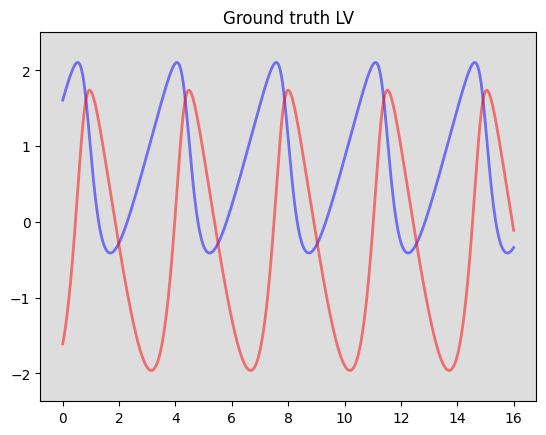

In [5]:
# define FitzHugh-Nagumo model dynamic
def LV(y, t, a, b, c, d):
	P, D = y # Prey, Predator
	dPdt = a * P - b * P * D
	dDdt = c * P * D - d * D
	return (dPdt,dDdt)
# model parameters
a, b, c, d = 1.5, 1, 1, 3
# initial condition
P0, D0 = 5, 0.2 
y0 = P0, D0
# time point for evaluation
tdata = np.linspace(0, 16, 1281)
# integration
xdata = odeint(LV, y0, tdata, args = (a,b,c,d))
xdata = np.log(xdata)


# visualization
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='V')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='R')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Ground truth LV')
plt.show()

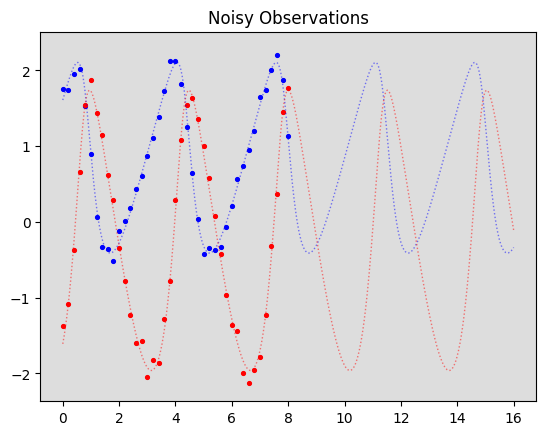

In [9]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [10]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 50.158783
200/1000 iteration: 11.631821
400/1000 iteration: 5.041573
600/1000 iteration: 3.141280
800/1000 iteration: 2.421721
1000/1000 iteration: 2.080723
run time: 74.07 seconds


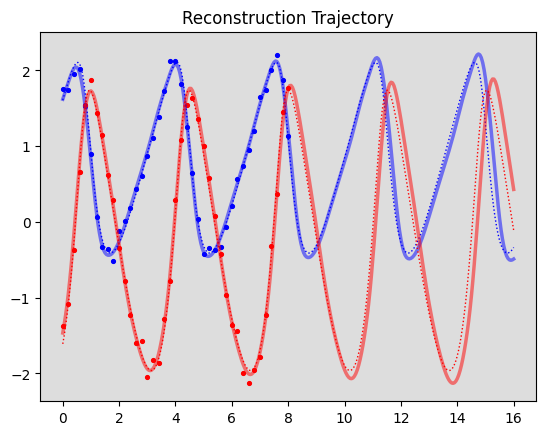

In [11]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

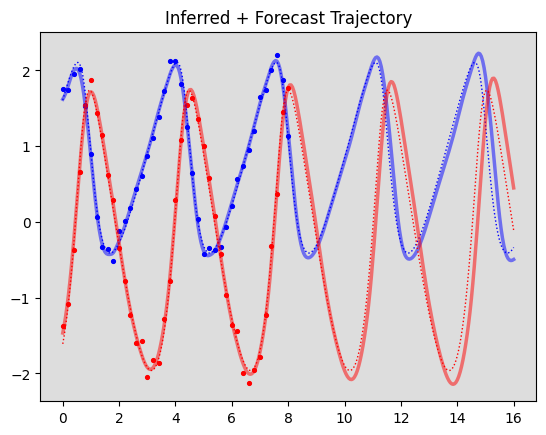

In [12]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

In [ ]:
# Add functions for vector field visualization
def compute_true_vector_field(grid_size=20, x_range=(0, 10), y_range=(0, 10)):
    """Compute the true vector field for the Lotka-Volterra model"""
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            derivs = LV([X[i, j], Y[i, j]], 0, a, b, c, d)
            U[i, j], V[i, j] = derivs[0], derivs[1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

def compute_vector_field(model, grid_size=20, x_range=(0, 10), y_range=(0, 10)):
    """Compute the vector field for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

def compute_estimated_nullclines(model, resolution=200, x_range=(0, 10), y_range=(0, 10)):
    """Compute the estimated nullclines for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(resolution):
        for j in range(resolution):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V}

def sample_training_data_for_visualization(states, max_points=1000):
    """Sample data points for visualization"""
    if states.shape[0] <= max_points:
        return states
    indices = np.linspace(0, states.shape[0]-1, max_points, dtype=int)
    return states[indices]

def plot_vector_field_comparison(true_vf, single_vf, multi_vf, single_model, multi_model, 
                                single_states, multi_states, filename="vector_field_comparison.png"):
    """Create a three-panel comparison of vector fields"""
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Calculate true nullclines for LV model
    x_range = np.linspace(0, 10, 1000)
    y_range = np.linspace(0, 10, 1000)
    
    # X-nullcline is where dX/dt = 0 => a*X - b*X*Y = 0 => Y = a/b (when X ≠ 0)
    # Y-nullcline is where dY/dt = 0 => c*X*Y - d*Y = 0 => X = d/c (when Y ≠ 0)
    x_null_y = np.ones_like(x_range) * (a/b)  # Horizontal line at Y = a/b
    y_null_x = np.ones_like(y_range) * (d/c)  # Vertical line at X = d/c
    
    # Plot true vector field
    q0 = axes[0].quiver(true_vf['X'], true_vf['Y'], true_vf['U'], true_vf['V'], 
                       true_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q0, ax=axes[0], label='Magnitude')
    axes[0].axhline(y=a/b, color='r', linestyle='-', linewidth=1.5, label='X-nullcline')
    axes[0].axvline(x=d/c, color='g', linestyle='-', linewidth=1.5, label='Y-nullcline')
    axes[0].set_title('True Vector Field')
    axes[0].legend(loc='upper right')
    
    # Plot single start vector field
    single_null = compute_estimated_nullclines(single_model)
    q1 = axes[1].quiver(single_vf['X'], single_vf['Y'], single_vf['U'], single_vf['V'], 
                       single_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q1, ax=axes[1], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[1].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[1].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    # Plot estimated nullclines
    axes[1].contour(single_null['X'], single_null['Y'], single_null['U'], 
                   levels=[0], colors=['r'], linewidths=1.5)
    axes[1].contour(single_null['X'], single_null['Y'], single_null['V'], 
                   levels=[0], colors=['g'], linewidths=1.5)
    
    # Plot training data points
    sampled_single = sample_training_data_for_visualization(single_states)
    axes[1].scatter(sampled_single[:, 0].numpy(), sampled_single[:, 1].numpy(), 
                   s=2.0, color='black', alpha=0.4)
    axes[1].set_title('Single Start Vector Field')
    
    # Plot multi start vector field
    multi_null = compute_estimated_nullclines(multi_model)
    q2 = axes[2].quiver(multi_vf['X'], multi_vf['Y'], multi_vf['U'], multi_vf['V'], 
                       multi_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q2, ax=axes[2], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[2].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[2].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    # Plot estimated nullclines
    axes[2].contour(multi_null['X'], multi_null['Y'], multi_null['U'], 
                   levels=[0], colors=['r'], linewidths=1.5)
    axes[2].contour(multi_null['X'], multi_null['Y'], multi_null['V'], 
                   levels=[0], colors=['g'], linewidths=1.5)
    
    # Plot training data points
    sampled_multi = sample_training_data_for_visualization(multi_states)
    axes[2].scatter(sampled_multi[:, 0].numpy(), sampled_multi[:, 1].numpy(), 
                   s=2.0, color='black', alpha=0.4)
    axes[2].set_title('Multiple Start Vector Field')
    
    # Set common properties
    for ax in axes:
        ax.set_xlabel('X (Prey)')
        ax.set_ylabel('Y (Predator)')
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.grid(True, alpha=0.3)
    
    # Set title
    fig.suptitle('Lotka-Volterra Vector Field Comparison', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

call function

In [ ]:
# Visualize the vector field for the FitzHugh-Nagumo model
create_vector_field_plot(fOde, obs=obs, title="LV Vector Field")

In [20]:
def compute_true_vector_field_log(grid_size=20,
                                 u_range=(-2, 3),
                                 v_range=(-2, 3)):
    """Compute the true vector field for the log‐transformed LV model."""
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    U, V = np.meshgrid(us, vs)

    X = np.exp(U)
    Y = np.exp(V)

    dU = (a*X - b*X*Y) / X
    dV = (c*X*Y - d*Y) / Y

    mag = np.sqrt(dU**2 + dV**2)
    return {'X': U, 'Y': V, 'U': dU, 'V': dV, 'magnitude': mag}

            
    magnitude = np.sqrt(U**2 + V**2)
    return {'X': log_X, 'Y': log_Y, 'U': U, 'V': V, 'magnitude': magnitude}

def compute_vector_field_log(model, grid_size=20, u_range=(-2, 3), v_range=(-2, 3)):
    """Compute the vector field for a neural network model trained on log data."""
    # mesh in (u,v) = (log Prey, log Predator)
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    log_X, log_Y = np.meshgrid(us, vs)

    U = np.zeros_like(log_X)
    V = np.zeros_like(log_Y)

    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([log_X[i, j], log_Y[i, j]],
                                  dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy().ravel()
            U[i, j], V[i, j] = d[0], d[1]

    magnitude = np.sqrt(U**2 + V**2)
    return {
      'X': log_X,
      'Y': log_Y,
      'U': U,
      'V': V,
      'magnitude': magnitude
    }

def compute_estimated_nullclines_log(model, resolution=200, u_range=(-2, 3), v_range=(-2, 3)):
    """Compute the estimated nullclines for a neural network model trained on log data"""
    log_x = np.linspace(x_range[0], x_range[1], resolution)
    log_y = np.linspace(y_range[0], y_range[1], resolution)
    log_X, log_Y = np.meshgrid(log_x, log_y)
    us = np.linspace(u_range[0], u_range[1], resolution)
    vs = np.linspace(v_range[0], v_range[1], resolution)
    U, V = np.meshgrid(us, vs)
    
    for i in range(resolution):
        for j in range(resolution):
            state = torch.tensor([log_X[i, j], log_Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
            
    return {'X': log_X, 'Y': log_Y, 'U': U, 'V': V}

def sample_training_data_for_visualization(states, max_points=1000):
    """Sample data points for visualization"""
    if states.shape[0] <= max_points:
        return states
    indices = np.linspace(0, states.shape[0]-1, max_points, dtype=int)
    return states[indices]

def plot_vector_field_comparison_log(true_vf, single_vf, multi_vf, single_model, multi_model, 
                                    single_states, multi_states, 
                                    x_range=(-2, 3), y_range=(-2, 3),
                                    filename="log_vector_field_comparison.png"):
    """Create a three-panel comparison of vector fields in log space"""
    # # Create figure
    # fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # # Calculate true nullclines for log-transformed LV model
    # log_x_nullcline = np.log(a/b)  # Log-transformed X-nullcline
    # log_y_nullcline = np.log(d/c)  # Log-transformed Y-nullcline
    
    # # Option 1: Standard quiver plot with properly scaled arrows
    # # Plot true vector field
    # q0 = axes[0].quiver(true_vf['X'], true_vf['Y'], true_vf['U'], true_vf['V'], 
    #                    true_vf['magnitude'], cmap=plt.cm.viridis, 
    #                    scale_units='xy', angles='xy', scale=0.5, width=0.004)
    # fig.colorbar(q0, ax=axes[0], label='Magnitude')
    # # Add a reference arrow
    # axes[0].quiverkey(q0, 0.9, 0.9, 0.5, "Magnitude = 0.5", labelpos='E', coordinates='axes')
    
    # # Plot single start vector field
    # single_null = compute_estimated_nullclines_log(model=single_model)
    # q1 = axes[1].quiver(single_vf['X'], single_vf['Y'], single_vf['U'], single_vf['V'], 
    #                    single_vf['magnitude'], cmap=plt.cm.viridis, 
    #                    scale_units='xy', angles='xy', scale=0.5, width=0.004)
    # fig.colorbar(q1, ax=axes[1], label='Magnitude')
    # # Add a reference arrow
    # axes[1].quiverkey(q1, 0.9, 0.9, 0.5, "Magnitude = 0.5", labelpos='E', coordinates='axes')
    
    # # Plot multi start vector field
    # multi_null = compute_estimated_nullclines_log(model=multi_model)
    # q2 = axes[2].quiver(multi_vf['X'], multi_vf['Y'], multi_vf['U'], multi_vf['V'], 
    #                    multi_vf['magnitude'], cmap=plt.cm.viridis, 
    #                    scale_units='xy', angles='xy', scale=0.5, width=0.004)
    # fig.colorbar(q2, ax=axes[2], label='Magnitude')
    # # Add a reference arrow
    # axes[2].quiverkey(q2, 0.9, 0.9, 0.5, "Magnitude = 0.5", labelpos='E', coordinates='axes')
    
    # # Add nullclines and other elements to each plot
    # for i, (ax, null, states, title, vf) in enumerate(zip(
    #     axes, 
    #     [None, single_null, multi_null],
    #     [None, single_states, multi_states],
    #     ['True Vector Field (Log Space)', 'Single Start Vector Field (Log Space)', 'Multiple Start Vector Field (Log Space)'],
    #     [true_vf, single_vf, multi_vf]
    # )):
    #     # Add true nullclines
    #     ax.axhline(y=log_x_nullcline, color='r', linestyle='-' if i==0 else '--', 
    #               linewidth=1.5, label='P-nullcline')
    #     ax.axvline(x=log_y_nullcline, color='g', linestyle='-' if i==0 else '--', 
    #               linewidth=1.5, label='D-nullcline')
        
    #     # Add estimated nullclines for models
    #     if i > 0:  # Skip for true vector field
    #         ax.contour(null['X'], null['Y'], null['U'], 
    #                   levels=[0], colors=['r'], linewidths=1.5, linestyles='-')
    #         ax.contour(null['X'], null['Y'], null['V'], 
    #                   levels=[0], colors=['g'], linewidths=1.5, linestyles='-')
            
    #         # Add training data points
    #         sampled = sample_training_data_for_visualization(states)
    #         ax.scatter(sampled[:, 0].numpy(), sampled[:, 1].numpy(), 
    #                   s=2.0, color='black', alpha=0.4)
        
    #     # Set title and customize plot
    #     ax.set_title(title)
    #     ax.set_xlabel('log(P) (Log Prey)')
    #     ax.set_ylabel('log(D) (Log Predator)')
    #     ax.set_xlim(x_range)
    #     ax.set_ylim(y_range)
    #     ax.grid(True, alpha=0.3)
        
    #     # Add legend
    #     if i == 0:
    #         ax.legend(loc='upper right')
        
    # # Set title
    # fig.suptitle('Log-Transformed Lotka-Volterra Vector Field Comparison', fontsize=16)
    
    # # Save figure
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    # plt.show()
    
    # Option 2: Normalized vectors with color representing magnitude
    # Create a second figure for normalized vectors
    fig2, axes2 = plt.subplots(1, 3, figsize=(20, 6))
    
    # Calculate normalization factors
    def normalize_vector_field(vf):
        norm = np.sqrt(vf['U']**2 + vf['V']**2)
        # Add small epsilon to avoid division by zero
        norm = np.where(norm < 1e-10, 1e-10, norm)
        return {'X': vf['X'], 'Y': vf['Y'], 
                'U': vf['U']/norm, 'V': vf['V']/norm, 
                'magnitude': vf['magnitude']}
    
    # Normalize vector fields
    true_vf_norm = normalize_vector_field(true_vf)
    single_vf_norm = normalize_vector_field(single_vf)
    multi_vf_norm = normalize_vector_field(multi_vf)
    
    # Quiver plots with normalized vectors (equal length)
    q0_norm = axes2[0].quiver(true_vf_norm['X'], true_vf_norm['Y'], 
                             true_vf_norm['U'], true_vf_norm['V'], 
                             true_vf['magnitude'], cmap=plt.cm.viridis, 
                             scale_units='xy', angles='xy', scale=5, width=0.004)
    fig2.colorbar(q0_norm, ax=axes2[0], label='Magnitude')
    
    q1_norm = axes2[1].quiver(single_vf_norm['X'], single_vf_norm['Y'], 
                             single_vf_norm['U'], single_vf_norm['V'], 
                             single_vf['magnitude'], cmap=plt.cm.viridis, 
                             scale_units='xy', angles='xy', scale=5, width=0.004)
    fig2.colorbar(q1_norm, ax=axes2[1], label='Magnitude')
    
    q2_norm = axes2[2].quiver(multi_vf_norm['X'], multi_vf_norm['Y'], 
                             multi_vf_norm['U'], multi_vf_norm['V'], 
                             multi_vf['magnitude'], cmap=plt.cm.viridis, 
                             scale_units='xy', angles='xy', scale=5, width=0.004)
    fig2.colorbar(q2_norm, ax=axes2[2], label='Magnitude')
    
    # Add nullclines and other elements to each plot
    for i, (ax, null, states, title, vf) in enumerate(zip(
        axes2, 
        [None, single_null, multi_null],
        [None, single_states, multi_states],
        ['True Direction Field (Log Space)', 'Single Start Direction Field (Log Space)', 'Multiple Start Direction Field (Log Space)'],
        [true_vf, single_vf, multi_vf]
    )):
        # Add true nullclines
        ax.axhline(y=log_x_nullcline, color='r', linestyle='-' if i==0 else '--', 
                  linewidth=1.5, label='P-nullcline')
        ax.axvline(x=log_y_nullcline, color='g', linestyle='-' if i==0 else '--', 
                  linewidth=1.5, label='D-nullcline')
        
        # Add estimated nullclines for models
        if i > 0:  # Skip for true vector field
            ax.contour(null['X'], null['Y'], null['U'], 
                      levels=[0], colors=['r'], linewidths=1.5, linestyles='-')
            ax.contour(null['X'], null['Y'], null['V'], 
                      levels=[0], colors=['g'], linewidths=1.5, linestyles='-')
            
            # Add training data points
            sampled = sample_training_data_for_visualization(states)
            ax.scatter(sampled[:, 0].numpy(), sampled[:, 1].numpy(), 
                      s=2.0, color='black', alpha=0.4)
        
        # Set title and customize plot
        ax.set_title(title)
        ax.set_xlabel('log(P) (Log Prey)')
        ax.set_ylabel('log(D) (Log Predator)')
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.grid(True, alpha=0.3)
        
        # Add legend
        if i == 0:
            ax.legend(loc='upper right')
    
    # Set title
    fig2.suptitle('Log-Transformed Lotka-Volterra Direction Field Comparison', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename.replace('.png', '_normalized.png'), dpi=300, bbox_inches='tight')
    plt.show()

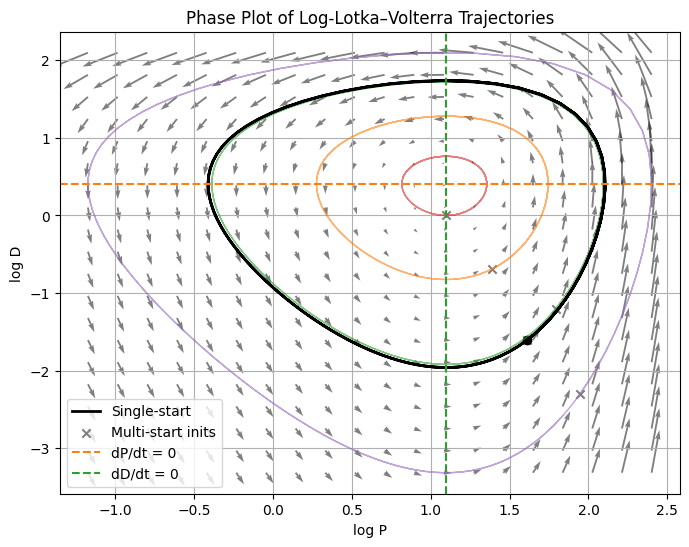

In [21]:
import numpy as np
import torch
from scipy.integrate import odeint

# 0) Define log-Lotka–Volterra
def LV(y, t, a=1.5, b=1.0, c=1.0, d=3.0):
    P, D = y
    return np.array([a*P - b*P*D,
                     c*P*D - d*D])

# 0b) Common time grid
t_max, n_points = 8, 201
tdata = np.linspace(0, t_max, n_points)

# 1) Single-start observations
P0, D0 = 5.0, 0.2
traj = odeint(LV, [P0, D0], tdata, args=(1.5,1,1,3))
log_traj = np.log(traj)   # shape (1281, 2)

# 1a) prepare ys: one tensor per dimension, each [time, log-value]
ys = [
    torch.tensor(np.column_stack((tdata, log_traj[:,0])), dtype=torch.double),
    torch.tensor(np.column_stack((tdata, log_traj[:,1])), dtype=torch.double),
]

# 2) Multi-start observations
starts = [
    [5.0, 0.2],
    [4.0, 0.5],
    [6.0, 0.3],
    [3.0, 1.0],
    [7.0, 0.1],
]

# simulate & log-transform each trajectory
all_trajs = []
for y0 in starts:
    traj_i = odeint(LV, y0, tdata, args=(1.5,1,1,3))
    all_trajs.append(np.log(traj_i))   # each (1281,2)

# 2a) build ys_mt: for each dim, stack [time, log-value] from all starts
ys_mt = []
for dim in range(2):
    blocks = [
        np.column_stack((tdata, all_trajs[i][:,dim]))
        for i in range(len(starts))
    ]
    big = np.vstack(blocks)  # shape (5*1281, 2)
    ys_mt.append(torch.tensor(big, dtype=torch.double))

# now `ys` goes into your single‐start MAGI-X and `ys_mt` into your multi‐start MAGI-X
import matplotlib.pyplot as plt

# 1) Pull out numpy arrays
#   single‐start:
single_logP = ys[0][:,1].numpy()    # log P
single_logD = ys[1][:,1].numpy()    # log D

#   multi‐start (stacked):
mt_logP_all = ys_mt[0][:,1].numpy()  # shape (n_starts * n_points,)
mt_logD_all = ys_mt[1][:,1].numpy()

# 2) reshape into (n_starts, n_points)
n_points = len(tdata)
n_starts = mt_logP_all.size // n_points
mt_logP = mt_logP_all.reshape(n_starts, n_points)
mt_logD = mt_logD_all.reshape(n_starts, n_points)

# 3) Plot
plt.figure(figsize=(8,6))

# Multi‐start loops
for i in range(n_starts):
    plt.plot(mt_logP[i], mt_logD[i], alpha=0.6, linewidth=1)

# Single‐start bold
plt.plot(single_logP, single_logD, 'k-', linewidth=2, label='Single-start')

# Mark initial points
plt.scatter(mt_logP[:,0], mt_logD[:,0], marker='x', color='gray', label='Multi-start inits')
plt.scatter(single_logP[0], single_logD[0], marker='o', color='k')

plt.xlabel('log P')
plt.ylabel('log D')
plt.title('Phase Plot of Log-Lotka–Volterra Trajectories')
plt.grid(True)

# 4) add nullclines and true vector field

# system parameters
a, b, c, d = 1.5, 1.0, 1.0, 3.0

# nullclines in log‐space
plt.axhline(np.log(a/b), linestyle='--', color='C1', label='dP/dt = 0')
plt.axvline(np.log(d/c), linestyle='--', color='C2', label='dD/dt = 0')

# prepare a grid over the same log‐ranges
lp_min, lp_max = mt_logP_all.min(), mt_logP_all.max()
ld_min, ld_max = mt_logD_all.min(), mt_logD_all.max()
n_grid = 20
lp = np.linspace(lp_min, lp_max, n_grid)
ld = np.linspace(ld_min, ld_max, n_grid)
LP, LD = np.meshgrid(lp, ld)

# back‐transform to P, D
Pg = np.exp(LP)
Dg = np.exp(LD)

# derivatives of log‐vars
U = (a*Pg - b*Pg*Dg) / Pg   # = a - b*Dg
V = (c*Pg*Dg - d*Dg) / Dg   # = c*Pg - d

# overlay vector field
plt.quiver(LP, LD, U, V, alpha=0.5)

# 5) update legend & redraw
plt.legend()
plt.show()


In [22]:
import numpy as np
import torch
from scipy.integrate import odeint
from scripts.magix.dynamic import nnSTModule, nnMTModule  # your single- and multi-start network classes :contentReference[oaicite:0]{index=0}&#8203;:contentReference[oaicite:1]{index=1}
from scripts.magix.inference import FMAGI                # the MAGI-X inference class :contentReference[oaicite:2]{index=2}&#8203;:contentReference[oaicite:3]{index=3}

# ensure double precision
torch.set_default_dtype(torch.double)

# --- your data setup (you already have these) ---
# tdata: (201,) np.array of time points from 0 to 12
# ys:  list of 2 torch.Tensors, each of shape (201, 2) = [t, log P] and [t, log D]
# ys_mt: list of 2 torch.Tensors, each of shape (5*201, 2) for multi-start

# 1) Single-start MAGI-X
fOde_st = nnSTModule(2, [512], dp=0.0)   # 2 inputs (log P, log D), one hidden layer of 512 units :contentReference[oaicite:4]{index=4}&#8203;:contentReference[oaicite:5]{index=5}
magi_st = FMAGI(
    ys,
    fOde_st,
    grid_size=201,
    interpolation_orders=3
)
t0_st, x_est_st = magi_st.map(
    max_epoch=2500,
    learning_rate=1e-3,
    decay_learning_rate=True,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=True,
    returnX=True
)

# 2) Multi-start MAGI-X
fOde_mt = nnMTModule(2, [512], dp=0.0)
magi_mt = FMAGI(
    ys_mt,
    fOde_mt,
    grid_size=201,
    interpolation_orders=3
)
t0_mt, x_est_mt = magi_mt.map(
    max_epoch=2500,
    learning_rate=1e-3,
    decay_learning_rate=True,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=True,
    returnX=True
)


1/2500 iteration: 2.090669
500/2500 iteration: 0.500385
1000/2500 iteration: 0.389002
1500/2500 iteration: 0.368847
2000/2500 iteration: 0.361706
2500/2500 iteration: 0.354527
1/2500 iteration: 22.228623
500/2500 iteration: 1.110298
1000/2500 iteration: 1.091994
1500/2500 iteration: 1.086977
2000/2500 iteration: 1.084213
2500/2500 iteration: 1.082209


In [23]:
def compute_vector_field_log(model,
                             grid_size=20,
                             u_range=(-2, 3),
                             v_range=(-2, 3)):
    """Return log-space mesh and learned dU,dV from `model`."""
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    U, V = np.meshgrid(us, vs)
    dU = np.zeros_like(U)
    dV = np.zeros_like(V)

    model.eval()
    with torch.no_grad():
        for i in range(grid_size):
            for j in range(grid_size):
                inp = torch.tensor([[U[i,j], V[i,j]]], dtype=torch.float64)
                out = model(inp).cpu().numpy().squeeze(0)
                dU[i,j], dV[i,j] = out[0], out[1]

    mag = np.sqrt(dU**2 + dV**2)
    return {'X': U, 'Y': V, 'U': dU, 'V': dV, 'magnitude': mag}


def compute_estimated_nullclines_log(model,
                                     resolution=200,
                                     u_range=(-2, 3),
                                     v_range=(-2, 3)):
    """Returns dense dU,dV so that contour(level=0) gives estimated nullclines."""
    us = np.linspace(u_range[0], u_range[1], resolution)
    vs = np.linspace(v_range[0], v_range[1], resolution)
    U, V = np.meshgrid(us, vs)
    dU = np.zeros_like(U)
    dV = np.zeros_like(V)

    model.eval()
    with torch.no_grad():
        for i in range(resolution):
            for j in range(resolution):
                inp = torch.tensor([[U[i,j], V[i,j]]], dtype=torch.float64)
                out = model(inp).cpu().numpy().squeeze(0)
                dU[i,j], dV[i,j] = out[0], out[1]

    return {'X': U, 'Y': V, 'U': dU, 'V': dV}

/tmp/ipykernel_3419804/1651808679.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


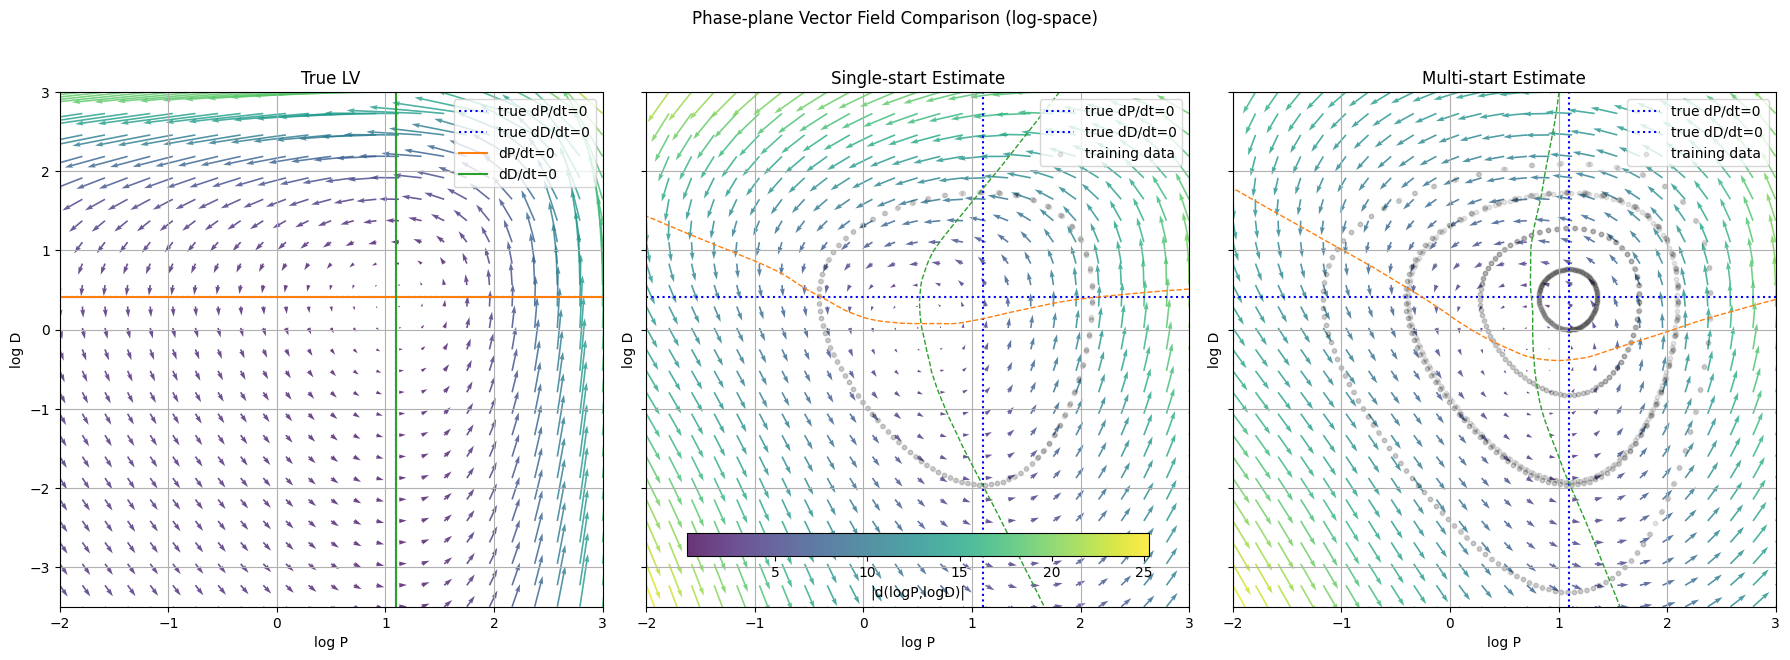

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_vector_field_comparison_log(ys, ys_mt, model_st, model_mt,
                                     compute_vector_field_log,
                                     compute_estimated_nullclines_log,
                                     a=1.5, b=1.0, c=1.0, d=3.0,
                                     grid_size=20, u_range=(-2, 3), v_range=(-2, 3),
                                     nullcline_resolution=200):
    """
    Compare true LV, single-start, and multi-start learned vector fields in log-space,
    coloring arrows by their absolute magnitude.
    """
    # 1) True LV field
    us = np.linspace(u_range[0], u_range[1], grid_size)
    vs = np.linspace(v_range[0], v_range[1], grid_size)
    Um, Vm = np.meshgrid(us, vs)
    Pg = np.exp(Um); Dg = np.exp(Vm)
    U_true = (a*Pg - b*Pg*Dg)/Pg      # = a - b*Dg
    V_true = (c*Pg*Dg - d*Dg)/Dg      # = c*Pg - d
    true_vf = {'X': Um, 'Y': Vm, 'U': U_true, 'V': V_true}

    # 2) Learned fields
    st_vf = compute_vector_field_log(model_st, grid_size, u_range, v_range)
    mt_vf = compute_vector_field_log(model_mt, grid_size, u_range, v_range)

    # 3) Nullcline estimates
    st_nc = compute_estimated_nullclines_log(model_st, nullcline_resolution, u_range, v_range)
    mt_nc = compute_estimated_nullclines_log(model_mt, nullcline_resolution, u_range, v_range)

    # 4) Training points
    P_st, D_st = ys[0][:,1].numpy(), ys[1][:,1].numpy()
    P_mt, D_mt = ys_mt[0][:,1].numpy(), ys_mt[1][:,1].numpy()

    # 5) Plot setup
    fig, axes = plt.subplots(1, 3, figsize=(18,6), sharex=True, sharey=True)
    titles = ['True LV', 'Single-start Estimate', 'Multi-start Estimate']
    fields = [true_vf, st_vf, mt_vf]
    nulls  = [None, st_nc, mt_nc]
    pts    = [None, (P_st, D_st), (P_mt, D_mt)]
    quivers = []

    for ax, title, vf, nc, data_pts in zip(axes, titles, fields, nulls, pts):
        # compute arrow magnitudes
        mag = np.sqrt(vf['U']**2 + vf['V']**2)

        # draw quiver, colored by |(U,V)|
        q = ax.quiver(
            vf['X'], vf['Y'], vf['U'], vf['V'],
            mag,
            cmap='viridis',
            scale_units='xy',
            angles='xy',
            scale=20,
            width=0.003,
            alpha=0.8
        )
        quivers.append(q)

        # nullclines
        ax.axhline(np.log(a/b), linestyle=':', color='blue', label='true dP/dt=0')
        ax.axvline(np.log(d/c), linestyle=':', color='blue', label='true dD/dt=0')
        if title == 'True LV':
            ax.axhline(np.log(a/b), linestyle='-', color='C1', label='dP/dt=0')
            ax.axvline(np.log(d/c), linestyle='-', color='C2', label='dD/dt=0')
        else:
            ax.contour(nc['X'], nc['Y'], nc['U'], levels=[0],
                       colors='C1', linestyles='--', linewidths=1)
            ax.contour(nc['X'], nc['Y'], nc['V'], levels=[0],
                       colors='C2', linestyles='--', linewidths=1)

        # training data
        if data_pts is not None:
            ax.scatter(data_pts[0], data_pts[1],
                       color='k', s=10, alpha=0.1, label='training data')

        # lock axes
        ax.set_xlim(u_range)
        ax.set_ylim(v_range)
        ax.set_title(title)
        ax.set_xlabel('log P')
        ax.set_ylabel('log D')
        ax.grid(True)
        ax.legend(loc='upper right')

    # shared colorbar
    cbar = fig.colorbar(quivers[0], ax=axes, orientation='horizontal',
                        fraction=0.05, pad=0.1, label='|d(logP,logD)|')
    fig.suptitle('Phase-plane Vector Field Comparison (log-space)', y=1.02)
    plt.tight_layout()
    plt.show()


# Example usage:
plot_vector_field_comparison_log(
    ys, ys_mt,
    fOde_st, fOde_mt,
    compute_vector_field_log,
    compute_estimated_nullclines_log,
    a=1.5, b=1.0, c=1.0, d=3.0,
    grid_size=25, u_range=(-2,3), v_range=(-3.5,3),
    nullcline_resolution=200
)
